# 🔬 Sample-based Quantum Diagonalization of a Chemistry Hamiltonian  
### 🧪 रसायन विज्ञान हैमिल्टोनियन का Sample-based Quantum Diagonalization

इस notebook में हम यह explore करेंगे कि sample-based quantum diagonalization तकनीक का उपयोग chemistry के complex Hamiltonians को approximate करने में कैसे किया जाता है।

Here, we will explore how sample-based quantum diagonalization can be applied to approximate the Hamiltonian of molecular systems in quantum chemistry.  
यह method hybrid quantum–classical computation का उपयोग करता है, जिसमें quantum circuit से bitstring samples लिए जाते हैं और फिर classical तरीके से उन samples का उपयोग करके Hamiltonian को diagonalize किया जाता है।

👉 यह विधि विशेष रूप से noisy quantum devices पर उपयोगी होती है, और यह large molecules जैसे nitrogen ($\mathrm{N}_2$) के ground state energy को estimate करने में मदद करती है।

---

## 🤔 Background / पृष्ठभूमि

In this tutorial, we show how to post-process noisy quantum samples to find an approximation to the ground state of the nitrogen molecule $\mathrm{N}_2$ at equilibrium bond length, using the [sample-based quantum diagonalization (SQD) algorithm](https://arxiv.org/abs/2405.05068), for samples taken from a 36-qubit quantum circuit (32 system qubits + 4 ancilla qubits). A Qiskit-based implementation is available in the [SQD Qiskit addons](https://github.com/Qiskit/qiskit-addon-sqd), and more details can be found in the corresponding [docs](/docs/guides/qiskit-addons-sqd) with a [simple example](/docs/guides/qiskit-addons-sqd-get-started) to get started.

इस ट्यूटोरियल में हम SQD algorithm का उपयोग करके noisy quantum samples का post-process करके नाइट्रोजन अणु ($\mathrm{N}_2$) के ground state का approximation निकालेंगे, जब अणु equilibrium bond length पर हो। हम samples लेते हैं एक 36-qubit circuit (32 system qubits + 4 ancilla qubits) से। Qiskit आधारित implementation [SQD Qiskit addons](https://github.com/Qiskit/qiskit-addon-sqd) में उपलब्ध है, और अधिक जानकारी के लिए संबंधित [docs](/docs/guides/qiskit-addons-sqd) और [simple example](/docs/guides/qiskit-addons-sqd-get-started) देखें।

SQD is a technique for finding eigenvalues and eigenvectors of quantum operators, such as a quantum system Hamiltonian, using quantum and distributed classical computing together. Classical distributed computing is used to process samples obtained from a quantum processor, and to project and diagonalize a target Hamiltonian in a subspace spanned by them. This allows SQD to be robust to samples corrupted by quantum noise and deal with large Hamiltonians, such as chemistry Hamiltonians with millions of interaction terms, beyond the reach of any exact diagonalization methods.

SQD एक तकनीक है जो quantum और distributed classical computing को मिलाकर quantum operators (जैसे system Hamiltonian) के eigenvalues और eigenvectors खोजती है। quantum processor से प्राप्त samples को classical distributed computing द्वारा process करके target Hamiltonian को उनके span किए subspace में project एवं diagonalize किया जाता है। इससे SQD noisy samples के खिलाफ robust रहता है और लाखों interaction terms वाले chemistry Hamiltonians जैसी बड़ी प्रणालियों को handle कर सकता है, जो exact diagonalization से परे हैं।

### SQD-based workflow / SQD आधारित वर्कफ़्लो

1. Choose a circuit ansatz and apply it on a quantum computer to a reference state (in this case, the [Hartree–Fock](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) state).  
2. Sample bitstrings from the resulting quantum state.  
3. Run the *self-consistent configuration recovery* procedure on the bitstrings to obtain the approximation to the ground state.

1. एक circuit ansatz चुनें और इसे quantum computer पर reference state (यहां [Hartree–Fock](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) state) के लिए लागू करें।  
2. प्राप्त quantum state से bitstrings का sampling करें।  
3. bitstrings पर *self-consistent configuration recovery* प्रक्रिया चलाकर ground state का approximation प्राप्त करें।

SQD works best when the target eigenstate is sparse: its wave function is supported on a set of basis states $\mathcal{S} = \{\lvert x\rangle\}$ whose size does not grow exponentially with problem size.

SQD तब बेहतरीन होता है जब target eigenstate sparse हो: इसकी wave function एक सीमित आधार सेट $\mathcal{S} = \{\lvert x\rangle\}$ पर supported होती है, जिसका आकार समस्या के बढ़ने के साथ exponentially नहीं बढ़ता।

---

## 🧪 Quantum chemistry / क्वांटम रसायन विज्ञान

The properties of molecules are largely determined by the structure of the electrons within them. As fermionic particles, electrons can be described using second quantization. There are a number of *orbitals*, each of which can be empty or occupied by one electron. A system with $N$ orbitals is described by fermionic annihilation operators $\{\hat{a}_p\}_{p=1}^N$ satisfying:

$$
\hat{a}_p \hat{a}_q + \hat{a}_q \hat{a}_p = 0, \quad
\hat{a}_p \hat{a}_q^\dagger + \hat{a}_q^\dagger \hat{a}_p = \delta_{pq}.
$$

Electrons’ spins introduce *spin-orbitals*. Each spatial orbital splits into two spin-orbitals (spin-$\alpha$, spin-$\beta$), giving $2N$ total spin-orbitals. The Hilbert space has dimension $2^{2N}$, with basis states labeled by bitstrings $\lvert z\rangle = \lvert z_\beta z_\alpha \rangle$.

अणुओं के गुण मुख्यतः उनके अंदर इलेक्ट्रॉनों की संरचना से निर्धारित होते हैं। फर्मियोनिक कणों के रूप में, इलेक्ट्रॉनों को सेकंड क्वांटाइजेशन द्वारा व्यक्त किया जाता है। प्रत्येक ऑर्बिटल खाली या एक इलेक्ट्रॉन द्वारा भरा हो सकता है। $N$ ऑर्बिटलों की प्रणाली को फर्मियोनिक annihilation ऑपरेटरों $\{\hat{a}_p\}_{p=1}^N$ द्वारा वर्णित किया जाता है, जो:

$$
\hat{a}_p \hat{a}_q + \hat{a}_q \hat{a}_p = 0, \quad
\hat{a}_p \hat{a}_q^\dagger + \hat{a}_q^\dagger \hat{a}_p = \delta_{pq}.
$$

को पूरा करते हैं।

जब spin को ध्यान में लेते हैं, तो हर spatial orbital दो spin-orbitals (spin-$\alpha$ और spin-$\beta$) में विभाजित होता है, जिससे कुल $2N$ spin-orbitals बनते हैं। Hilbert space आयाम $2^{2N}$ का होता है, और आधार राज्यों को bitstrings $\lvert z\rangle = \lvert z_\beta z_\alpha \rangle$ द्वारा लेबल किया जाता है।

The molecular Hamiltonian:

$$
\hat{H}
= \sum_{p,r,\sigma} h_{pr}\,\hat{a}_{p\sigma}^\dagger \hat{a}_{r\sigma}
+ \tfrac12
  \sum_{p,r,q,s,\sigma,\tau}
  h_{prqs}\,
  \hat{a}_{p\sigma}^\dagger
  \hat{a}_{q\tau}^\dagger
  \hat{a}_{s\tau}
  \hat{a}_{r\sigma},
$$

with molecular integrals $h_{pr}$, $h_{prqs}$ computed via [PySCF](https://pyscf.org/).

अणु का Hamiltonian इस प्रकार लिखा जाता है:

$$
\hat{H}
= \sum_{p,r,\sigma} h_{pr}\,\hat{a}_{p\sigma}^\dagger \hat{a}_{r\sigma}
+ \tfrac12
  \sum_{p,r,q,s,\sigma,\tau}
  h_{prqs}\,
  \hat{a}_{p\sigma}^\dagger
  \hat{a}_{q\tau}^\dagger
  \hat{a}_{s\tau}
  \hat{a}_{r\sigma},
$$

जहाँ $h_{pr},\,h_{prqs}$ molecular integrals हैं जिन्हें [PySCF](https://pyscf.org/) से प्राप्त किया जाता है।

For more, see *Modern Quantum Chemistry* (Szabo & Ostlund) and Qiskit Global Summer School lecture “Mapping Problems to Qubits” (https://youtu.be/TyFU6r8uEsE?t=900).

अधिक जानकारी के लिए देखें *Modern Quantum Chemistry* (Szabo & Ostlund) और Qiskit Global Summer School का लेक्चर “Mapping Problems to Qubits” (https://youtu.be/TyFU6r8uEsE?t=900)।

---

### Local unitary cluster Jastrow (LUCJ) ansatz  
#### स्थानीय यूनिटरी क्लस्टर जास्त्रू (LUCJ) ansatz

SQD requires a quantum circuit ansatz to draw samples from. In this tutorial, we’ll use the [LUCJ ansatz](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) for its physical motivation and hardware-friendliness.  
SQD को samples प्राप्त करने के लिए एक quantum circuit ansatz चाहिए। इस ट्यूटोरियल में हम [LUCJ ansatz](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) का उपयोग करेंगे क्योंकि यह भौतिक रूप से प्रेरणादायी और हार्डवेयर-फ्रेंडली है।

The general UCJ form:

$$
|\Psi\rangle
= \prod_{\mu=1}^L
  e^{\hat K_\mu}\,
  e^{i\hat J_\mu}\,
  e^{-\hat K_\mu}\,
  |\Phi_0\rangle,
$$

where

$$
\hat K_\mu = \sum_{p,q,\sigma} K_{pq}^\mu\,\hat a_{p\sigma}^\dagger \hat a_{q\sigma},
\quad
\hat J_\mu = \sum_{p,q,\sigma,\tau} J_{pq,\sigma\tau}^\mu\,\hat n_{p\sigma}\,\hat n_{q\tau},
\quad
\hat n_{p\sigma} = \hat a_{p\sigma}^\dagger \hat a_{p\sigma}.
$$

Implementing $e^{\hat K_\mu}$ is orbital rotation (linear depth, linear connectivity).  
Implementing $e^{i\hat J_\mu}$ normally needs all-to-all connectivity or fermionic swaps. LUCJ enforces sparsity on $\mathbf{J}^{\alpha\alpha}$, $\mathbf{J}^{\alpha\beta}$ so that $e^{i\hat J_\mu}$ runs in constant depth on limited-connectivity topologies.

---

#### Square lattice mapping example / स्क्वायर लैटिस मैपिंग उदाहरण

![Square lattice LUCJ mapping](/docs/images/tutorials/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd/baad4e53-5bfd-4cb4-8027-2ec26d27ecdd.avif)

$\mathbf{J}^{\alpha\alpha}: \{(p,p+1)\mid p=0,\dots,N-2\}$  
$\mathbf{J}^{\alpha\beta}: \{(p,p)\mid p=0,\dots,N-1\}$

---

#### Heavy-hex lattice mapping / हेवी-हेक्स लैटिस मैपिंग

![Heavy-hex lattice LUCJ mapping](/docs/images/tutorials/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd/7e0ee7e1-2d24-417f-ac59-25c58db79aa9.avif)

$\mathbf{J}^{\alpha\alpha}: \{(p,p+1)\mid p=0,\dots,N-2\}$  
$\mathbf{J}^{\alpha\beta}: \{(p,p)\mid p=0,4,8,\dots,\lfloor N-1\rfloor\}$

---

Ready to implement and sample with LUCJ? Next, we’ll build the circuit, run it on hardware via Qiskit Runtime, and feed samples into SQD recovery! 🚀  

### 🛠️ Self-consistent Configuration Recovery / आत्म-संगत विन्यास रिकवरी

The self-consistent configuration recovery procedure is designed to extract as much signal as possible from noisy quantum samples. Because the molecular Hamiltonian conserves particle number and spin-Z, it makes sense to choose a circuit ansatz that also conserves these symmetries. When applied to the Hartree–Fock state, the resulting state has a fixed particle number and spin-Z in the noiseless setting. Therefore, the spin-α and spin-β halves of any bitstring sampled from this state should have the same [Hamming weight](https://en.wikipedia.org/wiki/Hamming_weight) as in the Hartree–Fock state.  

आत्म-संगत विन्यास रिकवरी प्रक्रिया का उद्देश्य noisy quantum samples में से अधिक से अधिक signal बरकरार रखना है। चूंकि molecular Hamiltonian कण संख्या और spin-Z को संरक्षित रखता है, इसलिए एक ऐसा circuit ansatz चुनना उचित होता है जो ये ही symmetries बनाए रखे। Hartree–Fock state पर लागू होने पर, परिणामी state noiseless स्थिति में particle संख्या और spin-Z फ़िक्स रखती है। इसलिए इस state से sample किए गए किसी भी bitstring के spin-α और spin-β हिस्सों का [Hamming weight](https://en.wikipedia.org/wiki/Hamming_weight) Hartree–Fock state के समान होना चाहिए।

Due to noise in current quantum processors, some measured bitstrings will violate these symmetries. A simple postselection would discard them, but that wastes potentially useful data. The self-consistent recovery procedure iteratively “repairs” corrupted bitstrings instead of discarding them, improving the final ground-state estimate.  

वर्तमान quantum processors में noise के कारण कुछ measured bitstrings इन symmetries का उल्लंघन करेंगे। इन्हें सीधे हटा देना आसान होता है, लेकिन इससे उपयोगी डेटा बर्बाद हो सकता है। आत्म-संगत रिकवरी प्रक्रिया इन बिगड़े हुए bitstrings को हटाने के बजाय पुनर्प्राप्त करने का प्रयास करती है, जिससे अंतिम ground-state अनुमान में सुधार होता है।

#### Recovery Algorithm Steps / रिकवरी एल्गोरिदम के चरण

1. For each bitstring that violates the specified symmetries, flip bits probabilistically to bring it closer to the current estimate of average orbital occupancies, producing a new bitstring.  
   वे bitstrings जो symmetries का उल्लंघन करते हैं, उनके bit्स को probability-based तरीके से flip करें ताकि वे वर्तमान औसत ऑर्बिटल ओक्यूपेंसी अनुमान के करीब आ जाएं।

2. Collect all old and new bitstrings that now satisfy the symmetries, then subsample fixed-size subsets chosen in advance.  
   अब symmetries को पूरा करने वाले सभी पुराने और नए bitstrings इकट्ठा करें और इनमें से पहले से तय की गई संख्या के subsets चुनें।

3. For each subset, project the Hamiltonian into the subspace spanned by the corresponding basis vectors, then compute its ground-state estimate on a classical computer.  
   हर subset के लिए, Hamiltonian को संबंधित आधार vectors द्वारा स्पैन किए subspace में project करें, और फिर classical कंप्यूटर पर उसका ground-state estimate निकालें।

4. Update the average orbital occupancies estimate using the lowest-energy ground state from step 3, then repeat the loop until convergence.  
   चरण 3 में प्राप्त सबसे कम ऊर्जा वाले ground state का उपयोग करके औसत ऑर्बिटल ओक्यूपेंसी का अनुमान अपडेट करें, और convergence तक प्रक्रिया दोहराएं।

---

### 🔄 SQD Workflow Diagram / SQD वर्कफ़्लो आरेख

यहां SQD एल्गोरिदम के प्रमुख चरणों का आरेख दिया गया है:

![Workflow diagram of the SQD algorithm](/docs/images/tutorials/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd/fd7e816f-4e2e-4dd7-a7da-f71afb9ca68d.avif)

1. Circuit sampling  
2. Self-consistent recovery  
3. Subspace projection + classical diagonalization  
4. Ground-state update  

SQD integrates quantum sampling और classical post-processing को एक सतत लूप में, जिससे noisy devices पर भी विश्वसनीय ground-state अनुमान मिलते हैं।



## ⚙️ Requirements / आवश्यकताएँ

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* SQD Qiskit addon 0.11 or later (`pip install qiskit-addon-sqd`)
* ffsim (`pip install ffsim`)

इस ट्यूटोरियल को शुरू करने से पहले, सुनिश्चित करें कि आपके पास निम्न चीजें इंस्टॉल हैं:

* Qiskit SDK 1.0 या बाद का संस्करण visualization support के साथ (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 या बाद का संस्करण (`pip install qiskit-ibm-runtime`)
* SQD Qiskit addon 0.11 या बाद का संस्करण (`pip install qiskit-addon-sqd`)
* ffsim (`pip install ffsim`)



## Setup



In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

## 🎯 Step 1: Map Classical Inputs to a Quantum Problem / चरण 1: क्लासिकल इनपुट को क्वांटम समस्या में मैप करें

In this tutorial, we will find an approximation to the ground state of the molecule at equilibrium in the 6-31G basis set.  
इस ट्यूटोरियल में हम 6-31G बेसिस सेट में अणु के equilibrium पॉइंट पर ग्राउंड स्टेट का अनुमान लगाएंगे।  

---

### ⚙️ Define the Molecule and Its Properties / अणु और इसकी विशेषताएं परिभाषित करें

- Molecule geometry (atomic coordinates)  
  अणु की ज्यामिति (परमाणु निर्देशांक)  
- Basis set: 6-31G  
  बेसिस सेट: 6-31G  
- Charge: 0 (neutral molecule)  
  चार्ज: 0 (तटस्थ अणु)  
- Multiplicity: 1 (singlet state)  
  मल्टीप्लिसिटी: 1 (सिंगलेट अवस्था)  

---

अब हम इन Classical inputs को Qiskit में feed करेंगे और quantum Hamiltonian का निर्माण शुरू करेंगे।  
```python
# उदाहरण: जल अणु (H₂O) की ज्यामिति
molecule = """
O  0.000000  0.000000  0.000000
H  0.000000  0.000000  0.969700
H  0.000000  0.924200 -0.234600
"""
basis       = "6-31G"
charge      = 0
multiplicity= 1


In [2]:
# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


### 🔄 Pre-step: CCSD Calculation / CCSD गणना (पूर्व-चरण)

Before constructing the LUCJ ansatz circuit, we first perform a CCSD calculation in the following code cell. The $t_1$ and $t_2$ amplitudes from this calculation will be used to initialize the parameters of the ansatz.

LUCJ ansatz सर्किट तैयार करने से पहले, हम पहले निम्न कोड सेल में एक CCSD गणना करेंगे। इस गणना से प्राप्त $t_1$ और $t_2$ amplitudes का उपयोग ansatz के parameters को initialize करने के लिए किया जाएगा।

In [3]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988319


### 🔧 Use ffsim to Build the Ansatz Circuit / ffsim से ansatz सर्किट बनाएं

Now we use [ffsim](https://github.com/qiskit-community/ffsim) to create the ansatz circuit. Since our molecule has a closed-shell Hartree–Fock state, we select the spin-balanced variant [`UCJOpSpinBalanced`](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced). We pass interaction pairs tailored for a heavy-hex lattice qubit topology (see the [LUCJ ansatz background](#local-unitary-cluster-jastrow-lucj-ansatz)).  

अब हम ansatz सर्किट बनाने के लिए [ffsim](https://github.com/qiskit-community/ffsim) का उपयोग करेंगे। चूंकि हमारा अणु बंद-शेल Hartree–Fock अवस्था में है, इसलिए हम spin-balanced variant [`UCJOpSpinBalanced`](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced) का चयन करते हैं। हम heavy-hex लैटिस qubit टोपोलॉजी के लिए उपयुक्त interaction जोड़े प्रदान करते हैं (देखें [LUCJ ansatz पृष्ठभूमि](#local-unitary-cluster-jastrow-lucj-ansatz))।


In [4]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

## 🚀 Step 2: Optimize Problem for Quantum Hardware Execution / चरण 2: क्वांटम हार्डवेयर निष्पादन के लिए समस्या को अनुकूलित करें

Next, we optimize the circuit for a target hardware.  
अब हम अपने circuit को चुने हुए quantum hardware के लिए अनुकूलित करेंगे।


In [5]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

We recommend the following steps to make the ansatz hardware-compatible and reduce gate overhead:  
हम सुझाव देते हैं कि ansatz को हार्डवेयर-अनुकूल बनाने और gate ओवरहेड कम करने के लिए आप निम्नलिखित चरण अपनाएँ:

- Select physical qubits (`initial_layout`) from the target hardware that adhere to the “zig-zag” pattern described previously. Laying out qubits this way yields an efficient circuit with fewer gates.  
  लक्ष्य हार्डवेयर से “zig-zag” पैटर्न के अनुरूप physical qubits (`initial_layout`) चुनें। इस पैटर्न में qubit लेआउट करने से gate की संख्या कम होती है और circuit अधिक कुशल बनता है।  

- Generate a staged pass manager using Qiskit’s `generate_preset_pass_manager` function with your chosen `backend` and `initial_layout`.  
  अपने चुने हुए `backend` और `initial_layout` के साथ Qiskit के `generate_preset_pass_manager` फ़ंक्शन का उपयोग करके एक staged pass manager तैयार करें।  

- Set the `pre_init` stage of your staged pass manager to `ffsim.qiskit.PRE_INIT`. This stage includes passes that decompose gates into orbital rotations and then merge them, further reducing gate count.  
  अपने staged pass manager के `pre_init` चरण को `ffsim.qiskit.PRE_INIT` पर सेट करें। इस चरण में gates को orbital rotations में विभाजित करने और फिर उन्हें मर्ज करने वाले transpiler passes शामिल हैं, जिससे gate की संख्या और भी कम हो जाती है।  

- Run the pass manager on your circuit to produce the optimized, hardware-compatible circuit.  
  अपने circuit पर pass manager चलाएँ, जिससे optimized और hardware-compatible circuit बनेगा।  




<details>
  <summary>Code for automated selection of "zig-zag" layout</summary>

  <CodeCellPlaceholder tag="id-automated-layout-code" />
</details>



In [6]:
from typing import Sequence

import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph

IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}


def create_linear_chains(num_orbitals: int) -> PyGraph:
    """In zig-zag layout, there are two linear chains (with connecting qubits between
    the chains). This function creates those two linear chains: a rustworkx PyGraph
    with two disconnected linear chains. Each chain contains `num_orbitals` number
    of nodes, i.e., in the final graph there are `2 * num_orbitals` number of nodes.

    Args:
        num_orbitals (int): Number orbitals or nodes in each linear chain. They are
            also known as alpha-alpha interaction qubits.

    Returns:
        A rustworkx.PyGraph with two disconnected linear chains each with `num_orbitals`
            number of nodes.
    """
    G = rustworkx.PyGraph()

    for n in range(num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    for n in range(num_orbitals, 2 * num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals, 2 * num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    return G


def create_lucj_zigzag_layout(
    num_orbitals: int, backend_coupling_graph: PyGraph
) -> tuple[PyGraph, int]:
    """This function creates the complete zigzag graph that 'can be mapped' to a IBM QPU with
    heavy-hex connectivity (the zigzag must be an isomorphic sub-graph to the QPU/backend
    coupling graph for it to be mapped).
    The zigzag pattern includes both linear chains (alpha-alpha interactions) and connecting
    qubits between the linear chains (alpha-beta interactions).

    Args:
        num_orbitals (int): Number of orbitals, i.e., number of nodes in each alpha-alpha linear chain.
        backend_coupling_graph (PyGraph): The coupling graph of the backend on which the LUCJ ansatz
            will be mapped and run. This function takes the coupling graph as a undirected
            `rustworkx.PyGraph` where there is only one 'undirected' edge between two nodes,
            i.e., qubits. Usually, the coupling graph of a IBM backend is directed (e.g., Eagle devices
            such as ibm_sherbrooke) or may have two edges between two nodes (e.g., Heron `ibm_torino`).
            A user needs to be make such graphs undirected and/or remove duplicate edges to make them
            compatible with this function.

    Returns:
        G_new (PyGraph): The graph with IBM backend compliant zigzag pattern.
        num_alpha_beta_qubits (int): Number of connecting qubits between the linear chains
            in the zigzag pattern. While we want as many connecting (alpha-beta) qubits between
            the linear (alpha-alpha) chains, we cannot accommodate all due to qubit and connectivity
            constraints of backends. This is the maximum number of connecting qubits the zigzag pattern
            can have while being backend compliant (i.e., isomorphic to backend coupling graph).
    """
    isomorphic = False
    G = create_linear_chains(num_orbitals=num_orbitals)

    num_iters = num_orbitals
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(num_iters):
            if n % 4 == 0:
                new_node = 2 * num_orbitals + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + num_orbitals, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rustworkx.is_subgraph_isomorphic(
            backend_coupling_graph, G_new
        )
        num_iters -= 1

    return G_new, num_alpha_beta_qubits


def lightweight_layout_error_scoring(
    backend: BackendV2,
    virtual_edges: Sequence[Sequence[int]],
    physical_layouts: Sequence[int],
    two_q_gate_name: str,
) -> list[list[list[int], float]]:
    """Lightweight and heuristic function to score isomorphic layouts. There can be many zigzag patterns,
    each with different set of physical qubits, that can be mapped to a backend. Some of them may
    include less noise qubits and couplings than others. This function computes a simple error score
    for each such layout. It sums up 2Q gate error for all couplings in the zigzag pattern (layout) and
    measurement of errors of physical qubits in the layout to compute the error score.

    Note:
        This lightweight scoring can be refined using concepts such as mapomatic.

    Args:
        backend (BackendV2): A backend.
        virtual_edges (Sequence[Sequence[int]]): Edges in the device compliant zigzag pattern where
            nodes are numbered from 0 to (2 * num_orbitals + num_alpha_beta_qubits).
        physical_layouts (Sequence[int]): All physical layouts of the zigzag pattern that are isomorphic
            to each other and to the larger backend coupling map.
        two_q_gate_name (str): The name of the two-qubit gate of the backend. The name is used for fetching
            two-qubit gate error from backend properties.

    Returns:
        scores (list): A list of lists where each sublist contains two items. First item is the layout, and
            second item is a float representing error score of the layout. The layouts in the `scores` are
            sorted in the ascending order of error score.
    """
    props = backend.properties()
    scores = []
    for layout in physical_layouts:
        total_2q_error = 0
        for edge in virtual_edges:
            physical_edge = (layout[edge[0]], layout[edge[1]])
            try:
                ge = props.gate_error(two_q_gate_name, physical_edge)
            except Exception:
                ge = props.gate_error(two_q_gate_name, physical_edge[::-1])
            total_2q_error += ge
        total_measurement_error = 0
        for qubit in layout:
            meas_error = props.readout_error(qubit)
            total_measurement_error += meas_error
        scores.append([layout, total_2q_error + total_measurement_error])

    return sorted(scores, key=lambda x: x[1])


def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()

    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass

    return backend_coupling_graph


def get_zigzag_physical_layout(
    num_orbitals: int, backend: BackendV2, score_layouts: bool = True
) -> tuple[list[int], int]:
    """The main function that generates the zigzag pattern with physical qubits that can be used
    as an `intial_layout` in a preset passmanager/transpiler.

    Args:
        num_orbitals (int): Number of orbitals.
        backend (BackendV2): A backend.
        score_layouts (bool): Optional. If `True`, it uses the `lightweight_layout_error_scoring`
            function to score the isomorphic layouts and returns the layout with less erroneous qubits.
            If `False`, returns the first isomorphic subgraph.

    Returns:
        A tuple of device compliant layout (list[int]) with zigzag pattern and an int representing
            number of alpha-beta-interactions.
    """
    backend_coupling_graph = _make_backend_cmap_pygraph(backend=backend)

    G, num_alpha_beta_qubits = create_lucj_zigzag_layout(
        num_orbitals=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )

    isomorphic_mappings = rustworkx.vf2_mapping(
        backend_coupling_graph, G, subgraph=True
    )
    isomorphic_mappings = list(isomorphic_mappings)

    edges = list(G.edge_list())

    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout)

    two_q_gate_name = IBM_TWO_Q_GATES.intersection(
        backend.configuration().basis_gates
    ).pop()

    if score_layouts:
        scores = lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )

        return scores[0][0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

    return layouts[0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

In [7]:
initial_layout, _ = get_zigzag_physical_layout(num_orbitals, backend=backend)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'sx': 3537, 'rz': 3441, 'cz': 1366, 'x': 187, 'measure': 32, 'barrier': 1})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 2201, 'rz': 2123, 'cz': 730, 'x': 71, 'measure': 32, 'barrier': 1})


## 🚀 Step 3: Execute using Qiskit primitives / चरण 3: Qiskit प्रिमिटिव्स के साथ निष्पादन

After optimizing the circuit for hardware execution, we are ready to run it on the target hardware and collect samples for ground state energy estimation. As we only have one circuit, we will use Qiskit Runtime’s [Job execution mode](/docs/guides/execution-modes) and execute our circuit.

हार्डवेयर पर निष्पादन के लिए सर्किट को अनुकूलित करने के बाद, हम इसे चुने हुए हार्डवेयर पर चलाने और ground state ऊर्जा के अनुमान के लिए samples इकट्ठा करने के लिए तैयार हैं। चूंकि हमारे पास केवल एक सर्किट है, हम Qiskit Runtime के [Job execution mode](/docs/guides/execution-modes) का उपयोग करके अपना सर्किट execute करेंगे।


In [8]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

In [9]:
primitive_result = job.result()
pub_result = primitive_result[0]

## 🚀 Step 4: Post-process and Return Results in Desired Classical Format / चरण 4: पोस्ट-प्रोसेस करें और परिणाम को वांछित क्लासिकल फॉर्मेट में लौटाएँ

Now, we estimate the ground state energy of the Hamiltonian using the `diagonalize_fermionic_hamiltonian` function. This function performs the self-consistent configuration recovery procedure to iteratively refine the noisy quantum samples and improve the energy estimate. We pass a callback function so that we can save the intermediate results for later analysis. See the [API documentation](https://quantum.cloud.ibm.com/docs/en/api/qiskit-addon-sqd/fermion#diagonalize_fermionic_hamiltonian) for explanations of the arguments to `diagonalize_fermionic_hamiltonian`.  

अब हम `diagonalize_fermionic_hamiltonian` फ़ंक्शन का उपयोग करके हैमिल्टोनियन की ग्राउंड-स्टेट ऊर्जा का अनुमान लगाते हैं। यह फ़ंक्शन self-consistent configuration recovery प्रक्रिया लागू करता है, जो noisy quantum samples को क्रमिक रूप से परिष्कृत करके energy estimate बेहतर बनाता है। हम एक callback फ़ंक्शन पास करते हैं ताकि हम अंतरिम परिणाम बाद में विश्लेषण के लिए सहेज सकें। `diagonalize_fermionic_hamiltonian` के तर्कों के विवरण के लिए देखें [API दस्तावेज़](https://quantum.cloud.ibm.com/docs/en/api/qiskit-addon-sqd/fermion#diagonalize_fermionic_hamiltonian)।



In [10]:
from functools import partial

from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -109.01115387954262
		Subspace dimension: 121801
	Subsample 1
		Energy: -108.99766238342522
		Subspace dimension: 129600
	Subsample 2
		Energy: -108.9986709801191
		Subspace dimension: 130321
Iteration 2
	Subsample 0
		Energy: -109.0238112880712
		Subspace dimension: 236196
	Subsample 1
		Energy: -109.02439093236033
		Subspace dimension: 248004
	Subsample 2
		Energy: -109.02682540625446
		Subspace dimension: 232324
Iteration 3
	Subsample 0
		Energy: -109.0318317496183
		Subspace dimension: 345744
	Subsample 1
		Energy: -109.03307357984465
		Subspace dimension: 331776
	Subsample 2
		Energy: -109.03104229500951
		Subspace dimension: 335241
Iteration 4
	Subsample 0
		Energy: -109.03682184885335
		Subspace dimension: 422500
	Subsample 1
		Energy: -109.03558271049357
		Subspace dimension: 438244
	Subsample 2
		Energy: -109.03774432076236
		Subspace dimension: 419904
Iteration 5
	Subsample 0
		Energy: -109.04057366676442
		Subspace dimension: 544644
	Subsam

### 📊 Visualize the Results / परिणामों को विज़ुअलाइज़ करें

The first plot shows that after a couple of iterations we estimate the ground state energy within $\sim 7\ \mathrm{mH}$ (chemical accuracy is typically accepted to be $1\ \mathrm{kcal/mol} \approx 1.6\ \mathrm{mH}$). The energy can be improved by allowing more iterations of configuration recovery or increasing the number of samples per batch.

पहली plot दिखाती है कि कुछ iterations के बाद हम ground state ऊर्जा का अनुमान लगभग $7\ \mathrm{mH}$ के भीतर लगा लेते हैं (रासायनिक सटीकता सामान्यतः $1\ \mathrm{kcal/mol} \approx 1.6\ \mathrm{mH}$ मानी जाती है)। ऊर्जा के अनुमान को बेहतर बनाने के लिए configuration recovery के और iterations चलाएँ या प्रति बैच samples की संख्या बढ़ाएँ।

---

The second plot shows the average occupancy of each spatial orbital after the final iteration. We can see that both the spin-up and spin-down electrons occupy the first five orbitals with high probability in our solutions.

दूसरी plot दिखाती है कि अंतिम iteration के बाद प्रत्येक spatial orbital की औसत ओक्यूपेंसी क्या है। हम देख सकते हैं कि spin-up और spin-down दोनों इलेक्ट्रॉन हमारी समाधान में पहले पाँच ऑर्बिटल में उच्च संभावना के साथ उपस्थित रहते हैं।




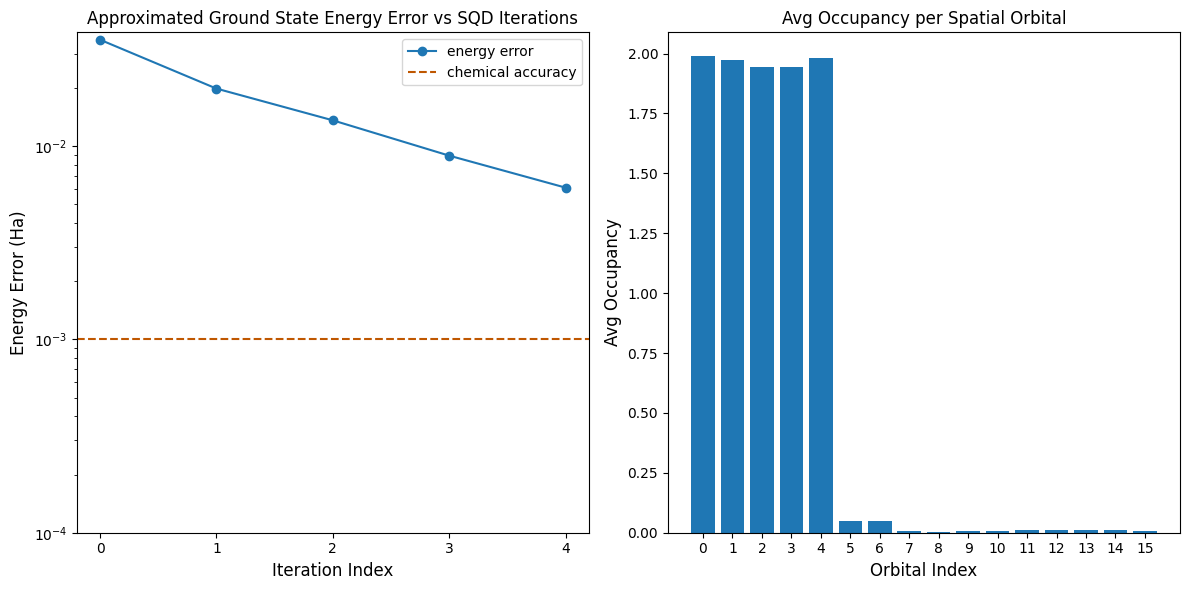

In [11]:
# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()